In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importing libraries
import pandas as pd
import os
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from src.models import parameter_learning as lfi
from src.models import build_model as build
from src.models import model_schemata as schema
from src.models import inference as inf
from src.visualization import visualize as viz

In [3]:
os.chdir('/Users/magdalena/OneDrive - Queen Mary, University of London/bezzlab/research/projects/phospho_pi/')
# os.chdir('/home/mhuebner/Desktop/bezzlab/research/projects/phospho_pi/')

In [4]:
runs = ['run1']

In [5]:
data = {}
for run in runs:
    with open(f'models/ebdt_data/p_model/predictions_marginf_relepev_{run}_20i.pkl', 'rb') as f:
        data[run] = pickle.load(f)

In [6]:
data

{'run1': {'p_occupancy': value phosphosite       sample         p_dec     p_inc        p_base
  0      AAK1(T389)        AC220  3.729905e-01  0.626855  1.546600e-04
  1      AAK1(T389)      AT13148  9.989512e-01  0.000001  1.047687e-03
  2      AAK1(T389)         AZ20  2.600795e-03  0.997168  2.307353e-04
  3      AAK1(T389)      AZD1480  9.574387e-01  0.041556  1.005694e-03
  4      AAK1(T389)      AZD3759  9.298961e-03  0.990612  8.891880e-05
  ...           ...          ...           ...       ...           ...
  70328   ZYX(S308)        Torin  1.415554e-07  1.000000  0.000000e+00
  70329   ZYX(S308)   Trametinib  6.896352e-04  0.999310  4.800000e-09
  70330   ZYX(S308)       U73122  2.804606e-11  1.000000  2.997195e-08
  70331   ZYX(S308)  Ulixertinib  9.952148e-01  0.004785  3.130000e-08
  70332   ZYX(S308)  Vemurafenib  9.983300e-01  0.001670  1.010000e-07
  
  [70333 rows x 5 columns]}}

#### Evaluation of learned parameters

In [7]:
p_fc = pd.read_csv('data/processed/ebdt_data/run1/p_fc.csv')

In [8]:
p_fc['p_base'] = 1 - p_fc['p_dec'] - p_fc['p_inc']
p_fc.loc[p_fc['p_base'] < 0, 'p_base'] = 0

In [9]:
analysis_dicts = inf.prep_experiments_for_auc(data, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0)

AUC curves

In [29]:
y_onehot_test_list = []
y_score_list = []
experiment_names = []
for exp in analysis_dicts.keys():
    y_onehot_test_list.append(analysis_dicts[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts[exp]['y_score'])
    experiment_names.append(exp)

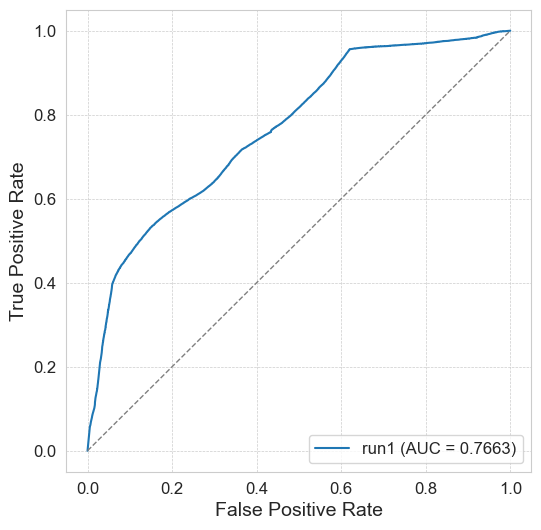

In [30]:
def plot_micro_average_roc_seaborn(y_onehot_tests, y_scores, experiment_names):
    n_experiments = len(experiment_names)

    # Apply Seaborn's default styling
    sns.set_style("whitegrid")

    plt.figure(figsize=(6, 6), dpi=100)

    for i in range(n_experiments):
        fpr, tpr, _ = roc_curve(y_onehot_tests[i].ravel(), y_scores[i].ravel())
        roc_auc = auc(fpr, tpr)

        # Set line style based on experiment number
        linestyle = "--" if i > 9 else "-"  # Dashed line for experiments after exp10

        plt.plot(
            fpr,
            tpr,
            label=f"{experiment_names[i].split('-')[0]} (AUC = {roc_auc:.4f})",
            linestyle=linestyle,
            linewidth=1.5,
        )

    # Add the reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)

    # Improve the grid, make it lighter
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Increase the legibility of the ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc='lower right', fontsize=12)

    plt.show()

# Usage example
plot_micro_average_roc_seaborn(y_onehot_test_list, y_score_list, experiment_names)

In [16]:
analysis_dicts_80 = inf.prep_experiments_for_auc(data, p_fc, result_type='p_occupancy', y_true_type='p_fc', threshold=0.8)

In [25]:
y_onehot_test_list = []
y_score_list = []
experiment_names = []
for exp in analysis_dicts_80.keys():
    y_onehot_test_list.append(analysis_dicts_80[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts_80[exp]['y_score'])
    experiment_names.append(exp)

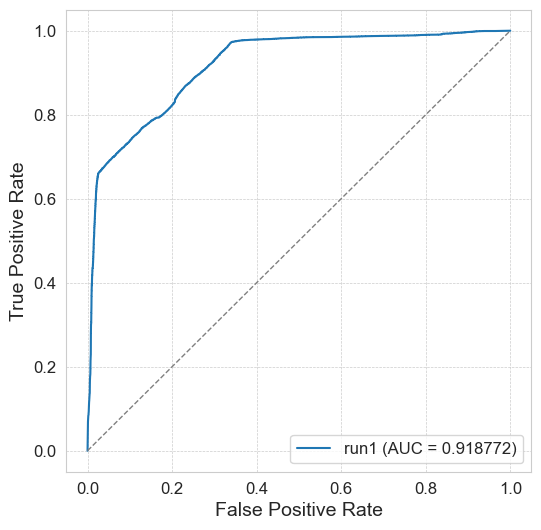

In [26]:
plot_micro_average_roc_seaborn(y_onehot_test_list, y_score_list, experiment_names)

In [31]:
y_onehot_test_list = []
y_score_list = []
experiment_names = []
for exp in analysis_dicts.keys():
    y_onehot_test_list.append(analysis_dicts[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts[exp]['y_score'])
    experiment_names.append(exp)
for exp in analysis_dicts_80.keys():
    y_onehot_test_list.append(analysis_dicts_80[exp]['y_onehot_test'])
    y_score_list.append(analysis_dicts_80[exp]['y_score'])
    experiment_names.append(f'{exp}_p>0.8')

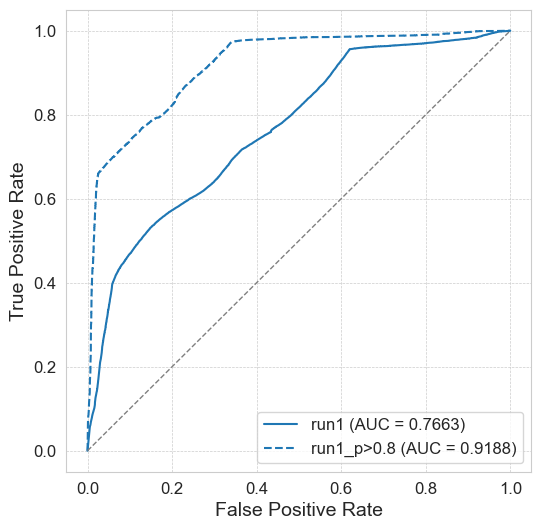

In [32]:
viz.plot_micro_average_roc_seaborn_paired(y_onehot_test_list, y_score_list, experiment_names)

Density plot

In [11]:
# Extracting data from your analysis dictionary
x = analysis_dicts['run1']['analysis_dataframe']['prob']
y = analysis_dicts['run1']['analysis_dataframe']['JSD']
mask_no_match = analysis_dicts['run1']['analysis_dataframe']['MaxMatch'] == 0
mask_gsk = (analysis_dicts['run1']['analysis_dataframe']['sample'] == 'Dabrafenib') & mask_no_match

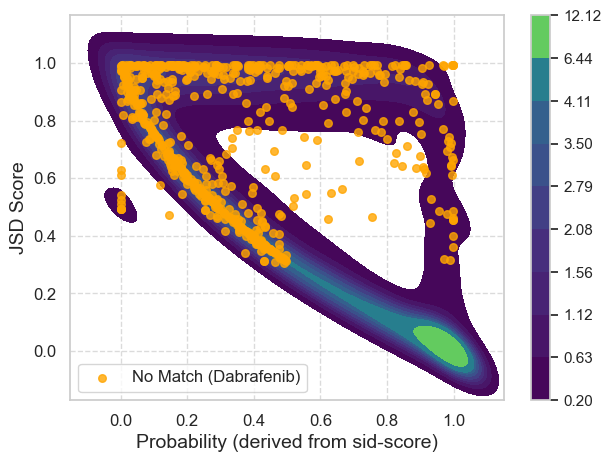

In [14]:
sns.set(style="whitegrid")  # Start with a white grid style

plt.figure(figsize=(7, 5), dpi=100)

# Create the kdeplot
sns.kdeplot(x=x, y=y, cmap='viridis', fill=True, levels=10, cbar=True)

# Scatter plot for 'MaxMatch' == 0 (Non Matches)
plt.scatter(x[mask_gsk], y[mask_gsk], c='orange', s=30, alpha=0.8, label='No Match (Dabrafenib)')

# Increase the legibility of the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding labels, title, and legend
plt.xlabel('Probability (derived from sid-score)', fontsize=14)
plt.ylabel('JSD Score', fontsize=14)
plt.legend(loc='lower left', fontsize=12)

# Enhance readability
plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()  # Adjusts the plot to ensure everything fits well

# Display the plot
plt.show()

Tables

In [15]:
mismatch_df = analysis_dicts['run1']['analysis_dataframe'][mask_gsk]

In [16]:
table1 = mismatch_df[mismatch_df['JSD'] > 0.98].sort_values(by=['prob'], ascending=[False]).head(9)
table1 = table1[['phosphosite', 'sample', 'max_category_p_fc', 'prob', 'max_category_p_occupancy', 'JSD']]
table1

,phosphosite,sample,max_category_p_fc,prob,max_category_p_occupancy,JSD
2365,HSP90AB1(S226),Dabrafenib,p_dec,0.997997,p_inc,0.993178
2147,U2AF2(S79),Dabrafenib,p_inc,0.997521,p_dec,0.993495
789,HSP90AA1(S263),Dabrafenib,p_dec,0.997493,p_inc,0.994281
2,LBR(S86),Dabrafenib,p_inc,0.995364,p_dec,0.994295
3324,NPM1(S137),Dabrafenib,p_dec,0.972339,p_inc,0.990818
11,TSPYL2(S20),Dabrafenib,p_inc,0.969566,p_dec,0.994295
417,NCKAP5L(S436),Dabrafenib,p_inc,0.924887,p_dec,0.994294
6041,TUBB3(S172),Dabrafenib,p_inc,0.905373,p_dec,0.984248
1863,FOXO1(S298),Dabrafenib,p_inc,0.858665,p_dec,0.993753


In [17]:
table2 = mismatch_df[mismatch_df['JSD'] > 0.98].sort_values(by=['prob'], ascending=[False]).tail(10)
table2 = table2[['phosphosite', 'sample', 'max_category_p_fc', 'prob', 'max_category_p_occupancy', 'JSD']]
table2

,phosphosite,sample,max_category_p_fc,prob,max_category_p_occupancy,JSD
6689,CAMSAP1(S1080),Dabrafenib,p_base,0.029085,p_dec,0.982145
1560,BAZ2A(S1184),Dabrafenib,p_base,0.027765,p_dec,0.994068
2404,DBNL(S283),Dabrafenib,p_base,0.025397,p_dec,0.993099
3206,HMGA2(S44),Dabrafenib,p_base,0.022764,p_dec,0.991189
632,CDK16(S153),Dabrafenib,p_base,0.017400,p_inc,0.994288
2590,DSP(S2849),Dabrafenib,p_base,0.003271,p_inc,0.992729
6007,DAPK3(S312),Dabrafenib,p_base,0.003218,p_dec,0.984333
2625,EEF1D(S162),Dabrafenib,p_base,0.003102,p_inc,0.992651
4197,SYN1(S551),Dabrafenib,p_base,0.001000,p_inc,0.988761
4247,ATF2(T69),Dabrafenib,p_base,0.001000,p_inc,0.988667


In [29]:
analysis_dicts['run1']['analysis_dataframe'][(analysis_dicts['run1']['analysis_dataframe']['phosphosite'] == 'TSC2(S939)') &
                                             (analysis_dicts['run1']['analysis_dataframe']['sample'] == 'GSK690693')]

,phosphosite,sample,value,prob,p_dec_p_fc,p_inc_p_fc,p_base_p_fc,p_dec_p_occupancy,p_inc_p_occupancy,p_base_p_occupancy,JSD,max_category_p_fc,max_category_p_occupancy,MaxMatch
67234,TSC2(S939),GSK690693,inc,0.998006,0.001,0.998006,0.000994,0.003757,0.996239,0.000005,0.001092,p_inc,p_inc,1
